In [1]:

import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import pydicom
import tensorflow as tf
from IPython.display import update_display
from subprocess import Popen
PATH = "/mnt/d/Datasets/CBIS-DDSM/"
imgPATH = PATH + "manifest-ZkhPvrLo5216730872708713142/"
ROI_PATH = '/mnt/d/Datasets/Vindr-Mammo/ROI/'
roi_path = PATH + "ROI/"
save = roi_path + 'augmented/'
# malignant_roi_path = PATH + "ROI/malignant/"
# fullimg_benign_path = PATH + "fullimg/benign/"
# fullimg_malignant_path = PATH + "fullimg/malignant/"
image_size=300
img_height=300
img_width=300
output_size=300
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(1,1))

2023-02-13 01:33:12.010915: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-13 01:33:12.536205: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jj/miniconda3/envs/tf/lib/python3.9/site-packages/cv2/../../lib64:/usr/local/cuda/include:/usr/local/cuda/lib64:/usr/local/cuda-11.2/lib64::/usr/local/cuda/extras/CUPTI/lib64:/home/jj/miniconda3/envs/tf/lib/
2023-02-13 01:33:12.536278: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugi

In [2]:
# for dirName, subdirList, fileList in os.walk(imgPATH):
    # for fname in fileList:
        # if fname.endswith('.dcm'):
            # dcm_path = dirName+'/'+fname
            # img_path = dirName+'/'+fname.replace('.dcm','.png')
            # Popen(['convert',dcm_path,img_path]).wait()

In [3]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation((0,0.2),fill_mode='constant'),
  tf.keras.layers.RandomZoom(height_factor=(-0.2,0.2),width_factor=(-0.2,0.2),fill_mode='constant'),
  tf.keras.layers.RandomTranslation(height_factor=(-0.1,0.1),width_factor=(-0.1,0.1),fill_mode='constant')
  ])

2023-02-13 01:33:13.016952: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-13 01:33:13.023698: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-13 01:33:13.023736: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-13 01:33:13.024164: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, 

In [4]:
calc_test = pd.read_csv(PATH + "calc_case_description_test_set.csv")
calc_train = pd.read_csv(PATH + "calc_case_description_train_set.csv")
mass_test = pd.read_csv(PATH + "mass_case_description_test_set.csv")
mass_train = pd.read_csv(PATH + "mass_case_description_train_set.csv")
calc_test = calc_test[['patient_id','left_or_right_breast','image_view','pathology']]
calc_train = calc_train[['patient_id','left_or_right_breast','image_view','pathology']]
mass_test = mass_test[['patient_id','left_or_right_breast','image_view','pathology']]
mass_train = mass_train[['patient_id','left_or_right_breast','image_view','pathology']]

In [5]:
def preprocess(file_path):
    data = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    # data = clahe.apply(data)
    other_pixels = cv2.countNonZero(data)
    # Calculate the concentration of black pixels
    total_pixels = data.shape[0] * data.shape[1]
    concentration = (total_pixels - other_pixels) / total_pixels
    print(concentration)
    if concentration > 0.7 :
        new_file_path = file_path.replace('1-1.png','1-2.png')
        if os.path.exists(new_file_path):
            data = cv2.imread(new_file_path, cv2.IMREAD_GRAYSCALE)
            avail =True
        else : 
            avail = False
    if avail:
        img=cv2.resize(data,(img_width,img_height))
    else:
        img = data
    return img

def process_image(file_path,data_set,category,file_save,augment=False):
    # image_dir = tf.compat.as_str(file_path.numpy())
    # image_dir = file_path
    # image = preprocess(image_dir)
    data = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    # data = clahe.apply(data)
    other_pixels = cv2.countNonZero(data)
    # Calculate the concentration of black pixels
    total_pixels = data.shape[0] * data.shape[1]
    concentration = (total_pixels - other_pixels) / total_pixels
    avail=True
    if concentration > 0.7 :
        new_file_path = file_path.replace('1-1.png','1-2.png')
        if os.path.exists(new_file_path):
            data = cv2.imread(new_file_path, cv2.IMREAD_GRAYSCALE)
            avail =True
        else : 
            avail = False
    if avail:
        data = cv2.medianBlur(data,5)
        data = clahe.apply(data)
        img=cv2.resize(data,(img_width,img_height))
        save_path = str(save) + str(data_set) +'/'+str(category)+'/'+str(file_save)
        print(save_path) 
        directory= str(save) + str(data_set) +'/'+str(category)
        if not os.path.exists(directory):
            os.makedirs(directory)
        cv2.imwrite(save_path+'_1.png',img)
        img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
        if augment:
            for i in range(augment):
                img2 = data_augmentation(img)    
                cv2.imwrite(save_path+'_'+str(i+2)+'.png',img2.numpy())

In [6]:
train_malignant = []
train_benign = []

In [7]:
for dirName, subdirList, fileList in os.walk(imgPATH):
    if 'ROI' in dirName.split('/')[-1] or 'cropped' in dirName.split('/')[-1]:
        for fname in fileList:
            if fname == '1-1.png':
                info = dirName.split('/')[-3].split('_')
                mam_type = info[0].split('-')
                if mam_type[0] == 'Calc':
                    if mam_type[1] == 'Test':
                        data_set = 'test'
                        data = calc_test
                    else:
                        data_set = 'train'
                        data = calc_train
                elif mam_type[0] == 'Mass':
                    if mam_type[1] == 'Test':
                        data_set = 'test'
                        data = mass_test
                    else:
                        data_set = 'train'
                        data = mass_train
                else: print(str(info) + ' is invalid.')
                patient = 'P_' + str(info[2])
                patient_data = data.loc[data['patient_id']==patient]
                side = patient_data.loc[patient_data['left_or_right_breast']==info[3]]
                view = side.loc[side['image_view']==info[4]]
                category = view['pathology'].to_numpy()
                if category[0] == 'MALIGNANT':
                    if data_set == 'train':
                        train_malignant.append(patient)
                else:
                    if data_set == 'train':
                        train_benign.append(patient)

         

In [8]:
rng = np.random.default_rng(seed=42)
train_malignant= rng.permutation(train_malignant)
train_benign= rng.permutation(train_benign)
# val_set = []
# val_set = val_set.extend(train_benign[:-int(0.2*len(train_benign))])
# print(val_set)
# val_set = val_set.extend(train_malignant[:-int(0.2*len(train_malignant))])
val_set = np.concatenate((train_benign[:int(0.2*len(train_benign))],train_malignant[:int(0.2*len(train_malignant))]))
print(val_set)

['P_00768' 'P_00743' 'P_00112' 'P_01838' 'P_00455' 'P_00991' 'P_00454'
 'P_02434' 'P_01887' 'P_00666' 'P_00247' 'P_01885' 'P_00977' 'P_00625'
 'P_00071' 'P_00767' 'P_00538' 'P_00008' 'P_00106' 'P_00826' 'P_00767'
 'P_00909' 'P_01710' 'P_01409' 'P_00556' 'P_01160' 'P_00895' 'P_01647'
 'P_01864' 'P_01737' 'P_02468' 'P_00471' 'P_00160' 'P_00091' 'P_00013'
 'P_00169' 'P_00010' 'P_00004' 'P_01435' 'P_01488' 'P_01243' 'P_00455'
 'P_00112' 'P_01330' 'P_00205' 'P_00255' 'P_01003' 'P_00432' 'P_00119'
 'P_00412' 'P_01644' 'P_00377' 'P_00378' 'P_00912' 'P_00487' 'P_00522'
 'P_01051' 'P_00600' 'P_00611' 'P_00866' 'P_00437' 'P_01336' 'P_01739'
 'P_00700' 'P_01437' 'P_00455' 'P_00106' 'P_00630' 'P_01826' 'P_01292'
 'P_00380' 'P_01741' 'P_01401' 'P_01566' 'P_01687' 'P_01169' 'P_00744'
 'P_00452' 'P_00816' 'P_01389' 'P_01297' 'P_00694' 'P_00764' 'P_00733'
 'P_01783' 'P_01686' 'P_01877' 'P_00767' 'P_00953' 'P_00279' 'P_01362'
 'P_01317' 'P_01437' 'P_01039' 'P_00044' 'P_00743' 'P_00731' 'P_01838'
 'P_00

In [9]:
for dirName, subdirList, fileList in os.walk(imgPATH):
    if 'ROI' in dirName.split('/')[-1] or 'cropped' in dirName.split('/')[-1]:
        for fname in fileList:
            if fname == '1-1.png':
                info = dirName.split('/')[-3].split('_')
                mam_type = info[0].split('-')
                if mam_type[0] == 'Calc':
                    if mam_type[1] == 'Test':
                        data_set = 'test'
                        data = calc_test
                    else:
                        data_set = 'train'
                        data = calc_train
                elif mam_type[0] == 'Mass':
                    if mam_type[1] == 'Test':
                        data_set = 'test'
                        data = mass_test
                    else:
                        data_set = 'train'
                        data = mass_train
                else: print(str(info) + ' is invalid.')
                patient = 'P_' + str(info[2])
                patient_data = data.loc[data['patient_id']==patient]
                side = patient_data.loc[patient_data['left_or_right_breast']==info[3]]
                view = side.loc[side['image_view']==info[4]]
                category = view['pathology'].to_numpy()
                if patient in val_set:
                    data_set= 'val'
                if category[0] == 'MALIGNANT':
                    category = 'malignant'
                else:
                    category = 'benign'
                file_save = '_'.join(info[1:])
                if data_set == 'train':
                    process_image(dirName+'/'+fname,data_set,category,file_save,augment=3)
                else:
                    process_image(dirName+'/'+fname,data_set,category,file_save)


            

/mnt/d/Datasets/CBIS-DDSM/ROI/augmented/test/benign/P_00562_LEFT_MLO_2
/mnt/d/Datasets/CBIS-DDSM/ROI/augmented/test/benign/P_00562_RIGHT_CC_1
/mnt/d/Datasets/CBIS-DDSM/ROI/augmented/test/benign/P_00562_RIGHT_MLO_1
/mnt/d/Datasets/CBIS-DDSM/ROI/augmented/test/malignant/P_00570_LEFT_MLO_1
/mnt/d/Datasets/CBIS-DDSM/ROI/augmented/test/benign/P_00579_LEFT_MLO_1
/mnt/d/Datasets/CBIS-DDSM/ROI/augmented/test/benign/P_00589_LEFT_CC_1
/mnt/d/Datasets/CBIS-DDSM/ROI/augmented/test/benign/P_00589_LEFT_MLO_1
/mnt/d/Datasets/CBIS-DDSM/ROI/augmented/test/benign/P_00608_LEFT_CC_1
/mnt/d/Datasets/CBIS-DDSM/ROI/augmented/test/benign/P_00608_LEFT_MLO_1
/mnt/d/Datasets/CBIS-DDSM/ROI/augmented/test/benign/P_00620_LEFT_CC_1
/mnt/d/Datasets/CBIS-DDSM/ROI/augmented/test/malignant/P_00643_LEFT_CC_1
/mnt/d/Datasets/CBIS-DDSM/ROI/augmented/test/malignant/P_00643_LEFT_MLO_1
/mnt/d/Datasets/CBIS-DDSM/ROI/augmented/test/malignant/P_00646_LEFT_CC_1
/mnt/d/Datasets/CBIS-DDSM/ROI/augmented/test/malignant/P_00646_LEFT_M

In [25]:
calc_test = pd.read_csv(PATH + "calc_case_description_test_set.csv")
calc_train = pd.read_csv(PATH + "calc_case_description_train_set.csv")
mass_test = pd.read_csv(PATH + "mass_case_description_test_set.csv")
mass_train = pd.read_csv(PATH + "mass_case_description_train_set.csv")
metadata = pd.read_csv(imgPATH + "metadata.csv")

In [26]:
calc_train_study_id = calc_train.ROI_mask_file_path.to_numpy()
calc_test_study_id = calc_test.ROI_mask_file_path.to_numpy()
mass_train_study_id = mass_train.ROI_mask_file_path.to_numpy()
mass_test_study_id = mass_test.ROI_mask_file_path.to_numpy()
calc_test_study_id = [i.split('/')[2] for i in calc_test_study_id]
calc_train_study_id = [i.split('/')[2] for i in calc_train_study_id]
mass_test_study_id = [i.split('/')[2] for i in mass_test_study_id]
mass_train_study_id = [i.split('/')[2] for i in mass_train_study_id]
calc_train_study_id_2 = calc_train.cropped_image_file_path.to_numpy()
calc_test_study_id_2 = calc_test.cropped_image_file_path.to_numpy()
mass_train_study_id_2 = mass_train.cropped_image_file_path.to_numpy()
mass_test_study_id_2 = mass_test.cropped_image_file_path.to_numpy()
calc_test_study_id_2 = [i.split('/')[2] for i in calc_test_study_id_2]
calc_train_study_id_2 = [i.split('/')[2] for i in calc_train_study_id_2]
mass_test_study_id_2 = [i.split('/')[2] for i in mass_test_study_id_2]
mass_train_study_id_2 = [i.split('/')[2] for i in mass_train_study_id_2]
calc_train_pathology = calc_train.pathology.to_numpy()
calc_test_pathology = calc_test.pathology.to_numpy()
mass_train_pathology = mass_train.pathology.to_numpy()
mass_test_pathology = mass_test.pathology.to_numpy()

In [27]:
def list_find(list=[], input=''):
    for y in list:
        for i,x in enumerate(y):
            if x == input:
                list_index = i
                return int(list_index)
    
    return print(input+' not found')

    
    


In [28]:
study_uid = metadata.Series_UID.to_numpy()
file_location = metadata.File_Location.to_numpy()
image_type = metadata.Series_Description.to_numpy()


In [29]:
# def read_monochrome1:

def ROI(image,img_h=0,img_w=0,xmin=0,xmax=0,ymin=0,ymax=0,save_path=None,size=300,monochrome=2):

    # data = pydicom.dcmread(image)
    # data = data.pixel_array.astype(float)
    data = (np.maximum(image,0)/image.max())*127.0
    data = np.uint8(data)
    # if xmin<0: xmin=0
    # if xmax>img_w: xmax=img_w
    # if ymin<0: ymin=0
    # if ymax>img_h: ymax=img_h
    # data = data[int(ymin):int(ymax),int(xmin):int(xmax)]
    if monochrome == 1:
        data = np.invert(data)
    data = cv2.medianBlur(data,3)
    data = clahe.apply(data)
    data = cv2.resize(data,(size,size))
    cv2.imwrite(save_path+'.png',data)



In [30]:
# print(study_uid[1])
# print(calc_train_study_id[344])
# Category = mass_test_pathology[list_find([mass_test_study_id,mass_test_study_id_2],'1.3.6.1.4.1.9590.100.1.2.423283243012912888204847591923699853302')]
# Category

In [31]:
# file = '/'.join(file_location[0].split('\\')[1:])
# for dirName, subdirList, fileList in os.walk(imgPATH+file):
#     for fname in fileList:
#         data = pydicom.dcmread(imgPATH+file+'/'+fname)
#         print(data.SeriesDescription == 'cropped images')

In [32]:
# ROIs = np.where(image_type =='ROI mask images')[0]
# x = ROIs[0]
# file_dir = '/'.join(file_location[x].split('\\')[1:])
# for dirName, subdirList, fileList in os.walk(imgPATH+file_dir):
#     row = 3000
#     for file in fileList:
#         print(imgPATH+file_dir+'/'+file)
#         data = pydicom.dcmread(imgPATH+file_dir+'/'+file)
#         print(data)
#         row_new = data.Rows
#         if row_new < row:
#             row = row_new
#             image = data.pixel_array.astype(float)
#             if data.PhotometricInterpretation == 'MONOCHROME 1':monochrome = 1
#             else: monochrome =2

In [33]:
ignore_id = []
for dirName, subdirList, fileList in os.walk(roi_path+'To_be_revised/'):
    for fname in fileList:
        if fname.endswith('.png'):
            ignore_id.append(fname.split('.')[0])
print(ignore_id)

['P_00288_RIGHT_CC_1', 'P_00293_LEFT_MLO_1', 'P_00328_LEFT_MLO_1', 'P_00336_LEFT_MLO_1', 'P_00337_LEFT_CC_1', 'P_00337_LEFT_MLO_1', 'P_00376_RIGHT_MLO_1', 'P_00376_RIGHT_MLO_2', 'P_00377_LEFT_CC_1', 'P_00476_RIGHT_CC_1', 'P_00539_RIGHT_CC_2', 'P_00539_RIGHT_CC_3', 'P_00539_RIGHT_CC_4', 'P_00539_RIGHT_MLO_1', 'P_00539_RIGHT_MLO_2', 'P_00539_RIGHT_MLO_3', 'P_00539_RIGHT_MLO_4', 'P_00573_RIGHT_MLO_1', 'P_00578_LEFT_MLO_1', 'P_00665_LEFT_MLO_1', 'P_00759_LEFT_MLO_2', 'P_00846_LEFT_CC_1', 'P_00846_LEFT_MLO_1', 'P_00862_LEFT_MLO_1', 'P_00906_LEFT_MLO_1', 'P_00916_RIGHT_MLO_1', 'P_01084_LEFT_MLO_3', 'P_01262_RIGHT_MLO_3']


In [34]:
Progress_display = display("0% completed",display_id="Progress_display")
ROIs = np.where(image_type =='ROI mask images')[0]
for i,x in enumerate(ROIs):
    file_type = file_location[x].split('\\')[2].split('_')[0].split('-')
    if file_type[0]=='Calc':
        if file_type[1] == 'Training':
            Category = calc_train_pathology[list_find([calc_train_study_id,calc_train_study_id_2],study_uid[x])]
            train_test_split = 'train'
        else:
            Category = calc_test_pathology[list_find([calc_test_study_id,calc_test_study_id_2],study_uid[x])]
            train_test_split = 'test'
    if file_type[0]=='Mass':
        if file_type[1] == 'Training':
            Category = mass_train_pathology[list_find([mass_train_study_id,mass_train_study_id_2],study_uid[x])]
            train_test_split = 'train'
        else:
            Category = mass_test_pathology[list_find([mass_test_study_id,mass_test_study_id_2],study_uid[x])]
            train_test_split = 'test'
    file_dir = '/'.join(file_location[x].split('\\')[1:])
    row = 3000
    for dirName, subdirList, fileList in os.walk(imgPATH+file_dir):
        for file in fileList:
            data = pydicom.dcmread(imgPATH+file_dir+'/'+file)
            row_new = data.Rows
            if row_new < row:
                row = row_new
                image = data.pixel_array.astype(float)
                if data.PhotometricInterpretation == 'MONOCHROME 1':monochrome = 1
                else: monochrome =2
    patient = '_'.join(file_location[x].split('\\')[2].split('_')[1:6])
    if Category == "BENIGN" or Category == "BENIGN_WITHOUT_CALLBACK":
        category = 'benign'
    elif Category == "MALIGNANT":
        category = 'malignant'
    if patient not in ignore_id:
        ROI(image,save_path=roi_path+train_test_split+'/'+category+'/'+patient,monochrome=monochrome,size=300)
    update_display(str(int(i/len(ROIs)*100))+"% completed",display_id="Progress_display")
    # update_display(str(int(i))+" completed",display_id="Progress_display")
    
                
    

'3560 completed'

In [46]:
Progress_display = display("0% completed",display_id="Progress_display")
for i,x in enumerate(category):
    if str(x) != "nan" and finding_category[i] != "['No Finding']":
        image_path=str(imgPATH+filename[i]+'/'+img_id[i]+".dicom")
        save_path = filename[i] + "_" + view[i] + "_" + side[i] + ".png"
        if monochrome[np.where(meta_img_id==img_id[i])] == 'MONOCHROME1':MONOCHROME = 1
        else:MONOCHROME = 2
        if x.split(" ")[1] == '3':
            if tran_test_split[i] =='training':
                ROI(image_path,height[i],width[i],mask_x_min[i],mask_x_max[i],mask_y_min[i],mask_y_max[i],str(ROI_PATH+"train/benign/"+save_path),300,MONOCHROME)
            elif tran_test_split[i] =='test':
                ROI(image_path,height[i],width[i],mask_x_min[i],mask_x_max[i],mask_y_min[i],mask_y_max[i],str(ROI_PATH+"test/benign/"+save_path),300,MONOCHROME)
            else:
                print("Error occured with image "+str(img_id[i]))
        elif x.split(" ")[1] == '4' or x.split(" ")[1] =='5':
            if tran_test_split[i] =='training':
                ROI(image_path,height[i],width[i],mask_x_min[i],mask_x_max[i],mask_y_min[i],mask_y_max[i],str(ROI_PATH+"train/malignant/"+save_path),300,MONOCHROME)
            elif tran_test_split[i] =='test':
                ROI(image_path,height[i],width[i],mask_x_min[i],mask_x_max[i],mask_y_min[i],mask_y_max[i],str(ROI_PATH+"test/malignant/"+save_path),300,MONOCHROME)
            else:
                print("Error occured with image "+str(img_id[i])) 
        else:
            print("Error occured with image "+str(img_id[i]))
    update_display(str(int(i/len(category)*100))+"% completed",display_id="Progress_display")
update_display("completed",display_id="Progress_display")
    

'completed'

# Testing

In [59]:
np.where(img_id == "523cdecbef6f4fa9ec4c49ead52846ba" )

(array([2094, 2095]),)

(3580, 2812)


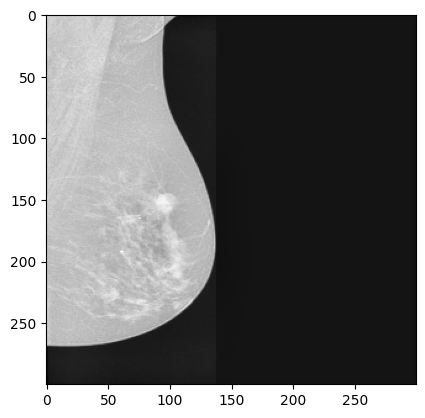

In [58]:
data = pydicom.dcmread(imgPATH+"afa015c6fcf47f108939c6663af44990/523cdecbef6f4fa9ec4c49ead52846ba.dicom")
# data = pydicom.dcmread(imgPATH+filename[0]+'/'+img_id[0]+".data")
data = data.pixel_array.astype(float)
data = (np.maximum(data,0)/data.max())*255.0

data = np.uint8(data)
# # # data = cv2.medianBlur(data,3)
# data = np.invert(data)
print(data.shape)

# data = data[int(mask_y_min[20140]):int(mask_y_max[20140]),int(mask_x_min[20140]):int(mask_x_max[20140])]
data = clahe.apply(data)
data = cv2.resize(data,(300,300))
plt.imshow(data, cmap="gray")

# cv2.imwrite(PATH+"test.png",data)